In [1]:
import pandas as pd
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
import keras
from keras import Model, Input
from keras.layers import Conv1D, Flatten, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, roc_auc_score
from keras.callbacks import TensorBoard, ModelCheckpoint
import seaborn as sns
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)


Num GPUs Available:  1


In [3]:
metadata = pd.read_csv('/content/drive/MyDrive/archive (17)/bird_songs_metadata.csv')
metadata.head()

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [4]:
# Lists for storing the filepaths and labels
file_paths = []
labels = []

audio_dir = '/content/drive/MyDrive/archive (17)/wavfiles/'

for index, row in metadata.iterrows():
    file_path = os.path.join(audio_dir, row['filename'])
    if os.path.exists(file_path):
        file_paths.append(file_path)
        labels.append(row['species'])

file_paths[:5], labels[:5]

(['/content/drive/MyDrive/archive (17)/wavfiles/557838-0.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-1.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-4.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-5.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-6.wav'],
 ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii'])

In [5]:
bird_labels = metadata['species']
bird_labels = bird_labels.values
bird_labels[bird_labels == ['bewickii']] = 0
bird_labels[bird_labels == ['polyglottos']] = 1
bird_labels[bird_labels == ['migratorius']] = 2
bird_labels[bird_labels == ['melodia']] = 3
bird_labels[bird_labels == ['cardinalis']] = 4
bird_labels = np.squeeze(bird_labels)

In [6]:
# Function to read audio file
def read_file(path):
    y, _ = librosa.load(path, sr=22050)  # Set the sample rate to ensure consistency
    return y

# Function to convert to dB scale
def spec_to_db(y):
    y_db = librosa.power_to_db(y, ref=np.max)
    #y_db = librosa.amplitude_to_db(y, ref=100)
    return y_db

# Map function that returns spectrograms
def map_function(path_tensor, label):
    # Load audio file
    y = tf.numpy_function(read_file, inp=[path_tensor], Tout=tf.float32)

    # Compute the Short-Time Fourier Transform (STFT)
    spectrogram = tf.abs(tf.signal.stft(y, frame_length=512, frame_step=64))

    mel_weights = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=128,
        num_spectrogram_bins=tf.shape(spectrogram)[-1],
        sample_rate=22050,
        lower_edge_hertz=0.0,
        upper_edge_hertz=8000.0)
    mel_spectrogram = tf.matmul(spectrogram, mel_weights)

    # Convert to dB scale
    #log_mel_spectrogram = tf.numpy_function(spec_to_db, inp=[mel_spectrogram], Tout=tf.float32)

    #spectrogram_db = tf.numpy_function(spec_to_db, inp = [spectrogram], Tout = tf.float32)
    #spectrogram_db = spectrogram_db/80+1

    return mel_spectrogram, label


def make_dataset(bird_labels, file_paths, shuffle):
    bird_labels = tf.convert_to_tensor(bird_labels, dtype = tf.int32)
    file_paths = tf.convert_to_tensor(file_paths, dtype = tf.string)

    bird_labels = tf.data.Dataset.from_tensor_slices(bird_labels)
    file_paths = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = tf.data.Dataset.zip( file_paths, bird_labels)

    if shuffle:
        dataset = dataset.shuffle(buffer_size = dataset.cardinality(), reshuffle_each_iteration=True)
    dataset = dataset.map(map_function, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size = 64, num_parallel_calls = tf.data.AUTOTUNE, drop_remainder = True)

    return dataset

In [7]:
file_paths_train, file_paths_test, y_train, y_test = train_test_split(
    file_paths, bird_labels, test_size=0.20, random_state=42)

dataset_train = make_dataset(y_train, file_paths_train, shuffle=True)
dataset_test = make_dataset(y_test, file_paths_test, shuffle=False)

for batch in dataset_train.take(1):
    input_data_shape = batch[0].shape
print("Shape of input data in training dataset:", input_data_shape)

Shape of input data in training dataset: (64, 1026, 128)


In [ ]:
import zipfile

def unzip_file(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)


zip_file_path = '/model.zip'
extract_to = '/content/model'

unzip_file(zip_file_path, extract_to)

In [8]:
model_eval = tf.keras.models.load_model('/content/model')
model_eval.summary()

Model: "Bird_audio_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_Input_shape (InputLayer)  [(None, 1026, 128)]       0         
                                                                 
 1_Conv1D (Conv1D)           (None, 513, 64)           65600     
                                                                 
 2_SpatialDropout1D (Spatia  (None, 513, 64)           0         
 lDropout1D)                                                     
                                                                 
 3_Conv1d (Conv1D)           (None, 257, 64)           32832     
                                                                 
 4_SpatialDropout1D (Spatia  (None, 257, 64)           0         
 lDropout1D)                                                     
                                                                 
 5_Conv1d (Conv1D)           (None,

In [9]:
model_eval.evaluate(dataset_test, return_dict=True)

16/16 [==============================] - 149s 9s/step - loss: 0.1741 - sparse_categorical_accuracy: 0.9551


{'loss': 0.17405128479003906, 'sparse_categorical_accuracy': 0.955078125}

In [10]:
last_conv_layer = model_eval.get_layer("7_Conv1d")
last_conv_layer_model = tf.keras.Model(model_eval.inputs, last_conv_layer.output)

In [11]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["8_SpatialDropout1D", "9_Global_avg_pooling", "10_Dense", "11_Dropout", "12_Dense"]:
    x = model_eval.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

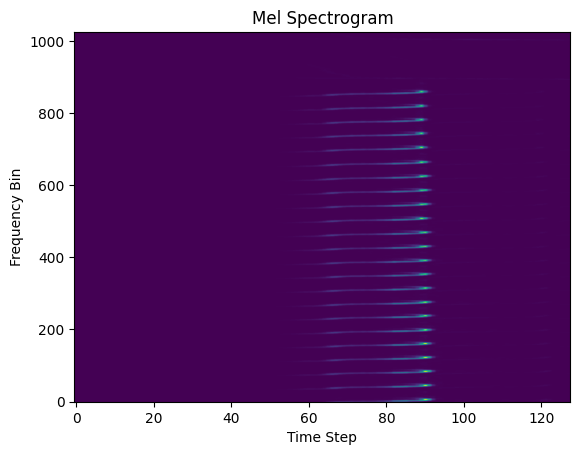

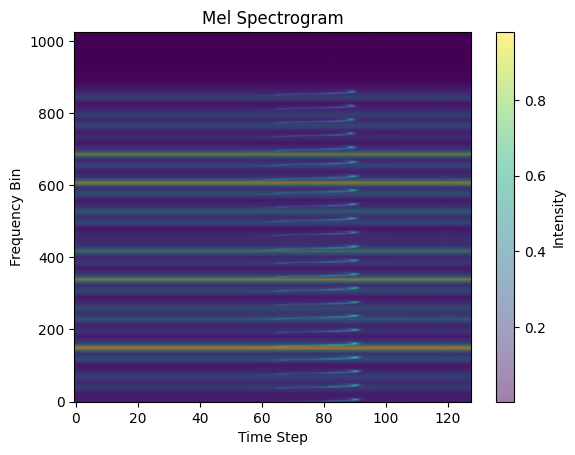

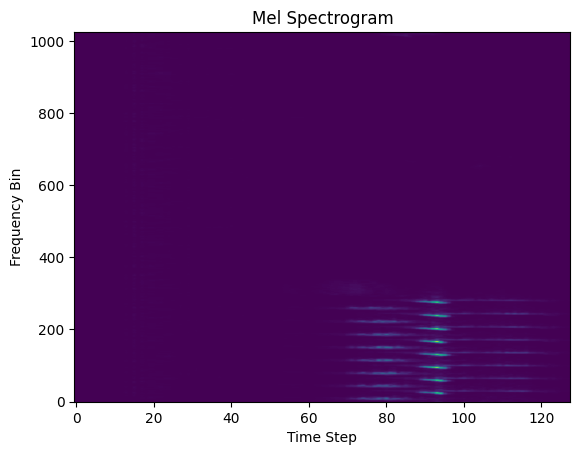

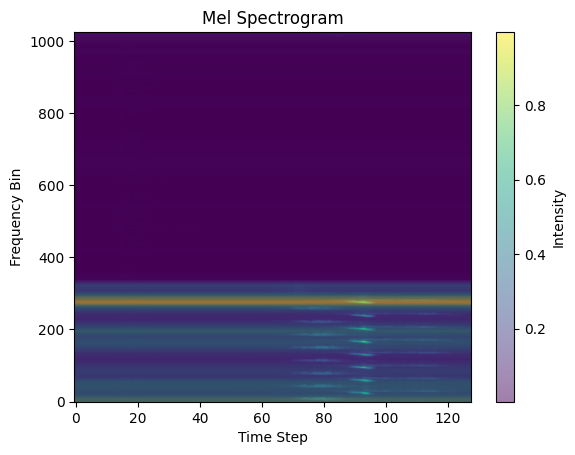

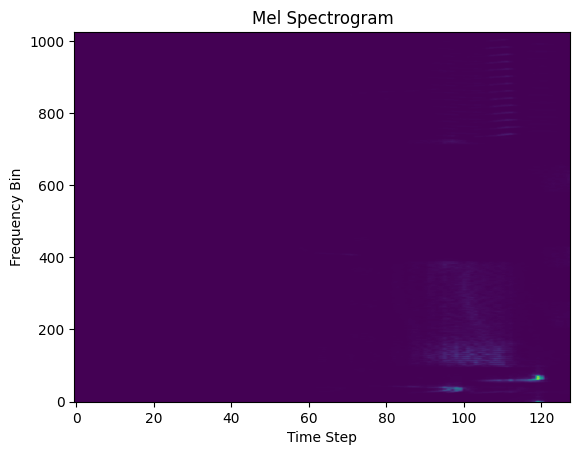

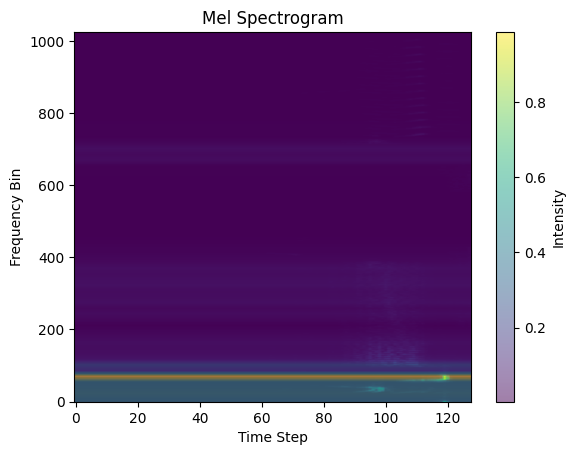

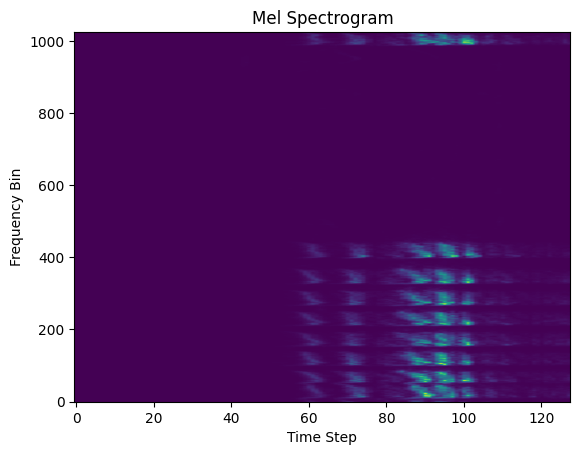

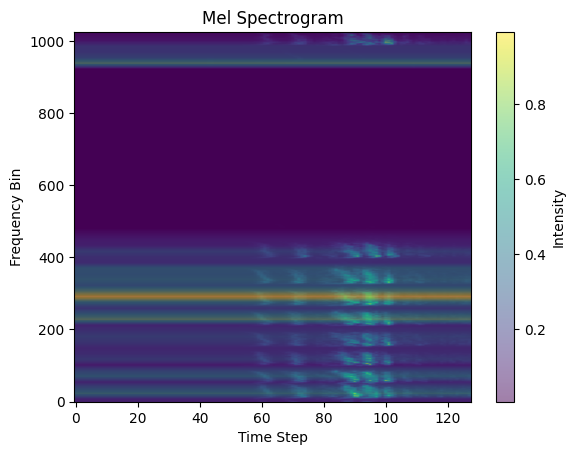

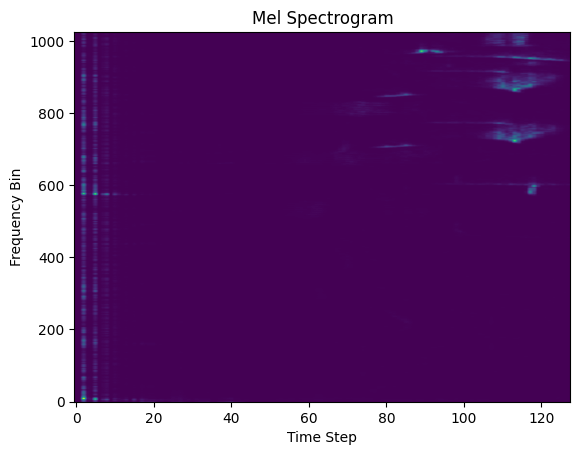

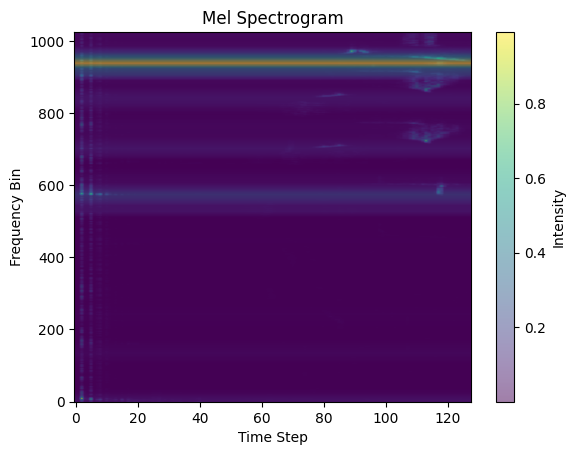

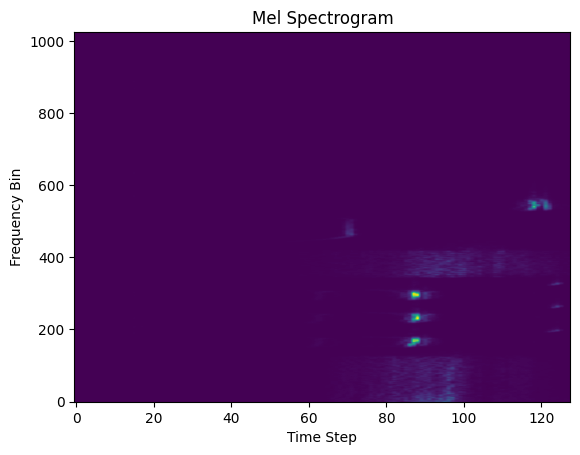

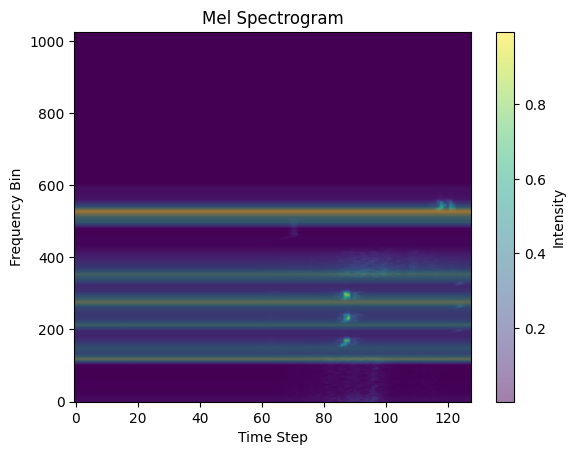

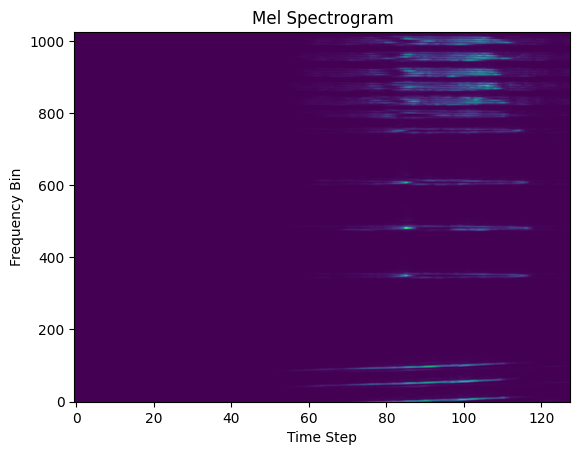

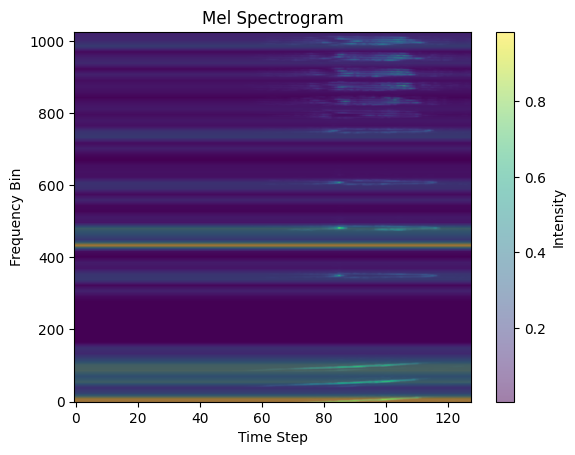

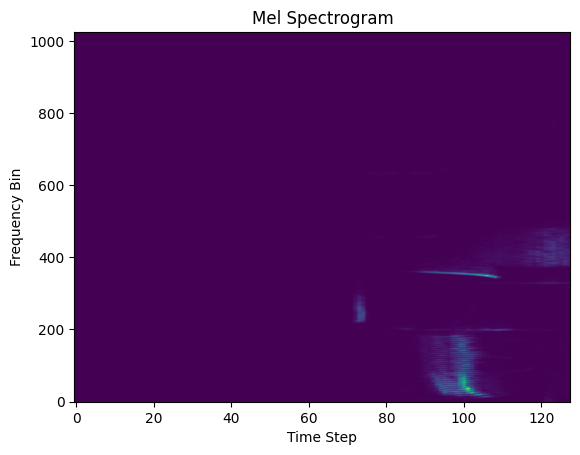

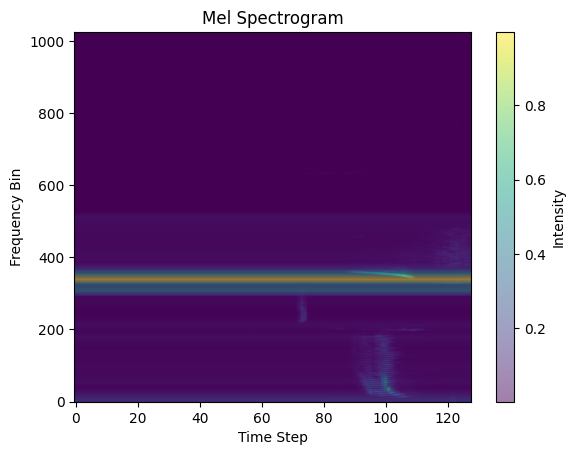

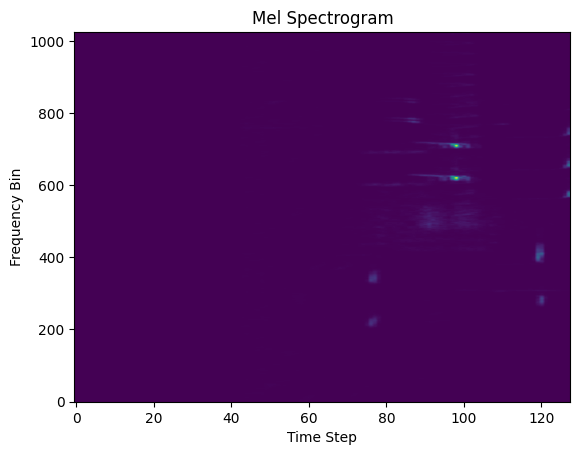

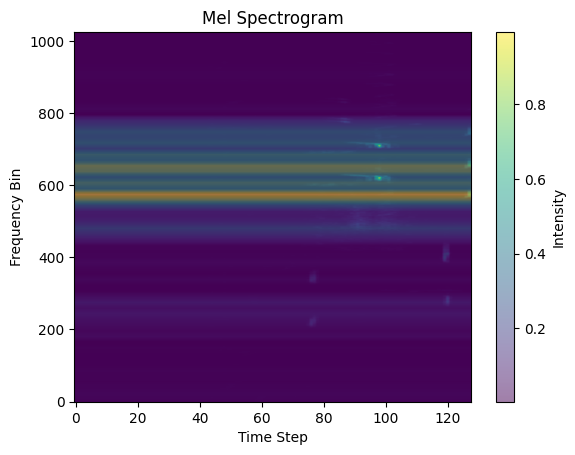

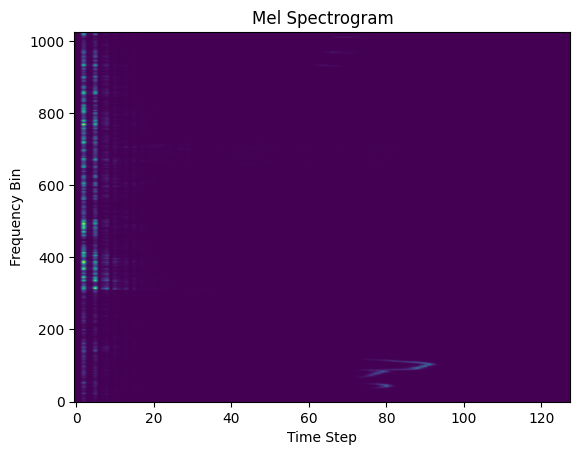

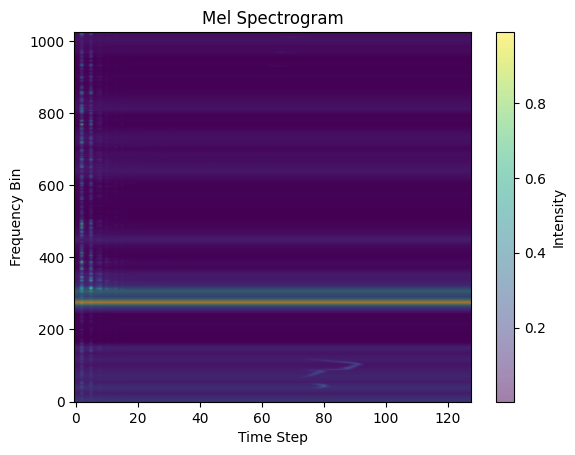

In [12]:
for batch in dataset_test.take(10):
    interpret_data = batch[0]
    mel_spectrogram = interpret_data[0, :, :]
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
    plt.xlabel('Time Step')
    plt.ylabel('Frequency Bin')
    plt.title('Mel Spectrogram')
    plt.show()

    mel_spectrogram_expanded = mel_spectrogram[np.newaxis, ...]

    # Compute gradients of the top predicted class with respect to the last convolutional layer output
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(mel_spectrogram_expanded)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)


    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, i] *= pooled_grads[i]

    gradcam = np.mean(last_conv_layer_output, axis=-1)
    gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    gradcam = cv2.resize(gradcam, (128, 1026))

    plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
    plt.imshow(gradcam, aspect='auto', cmap='viridis', alpha=0.5, interpolation='nearest')
    plt.gca().invert_yaxis()
    plt.xlabel('Time Step')
    plt.ylabel('Frequency Bin')
    plt.title('Mel Spectrogram')
    cbar = plt.colorbar()
    cbar.set_label('Intensity')
    plt.show()
